In [11]:
import time
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from utils.balance_data import Oversampler
from utils.base_models import BaseModels
from utils.numerical_scalers import NumericalScalers
from utils.categorical_encoders import CategoricalEncoders

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### 1. Leer datasets

In [12]:
# 1. Leer el dataset
dataset = pd.read_parquet('./data/2_data_preprocesada.parquet')
dataset = dataset.drop(columns=['DF_TYPE'])

# Seleccionar aleatoriamente el 10% de los datos
dataset = dataset.sample(frac=0.002, random_state=42)
print(dataset.shape)
print(dataset['TARGET'].value_counts())

(2611, 14)
TARGET
0    1371
1    1240
Name: count, dtype: int64


### 2. Generar combinaciones de categóricos y numéricos

In [13]:
# 2. Separar TARGET, df_categorical y df_numeric
df_target = dataset['TARGET']
df_categorical = dataset.select_dtypes(include=['object'])
df_numeric = dataset.select_dtypes(include=['float64', 'int64'])

# 3. Eliminar TARGET de df_numeric
df_numeric = df_numeric.drop(columns=['TARGET'])

In [14]:
# 4. Generar las combinaciones de Encoder y Scaler
encoder_methods = ['OneHotEncoder', 'OrdinalEncoder', 'BinaryEncoder', 'BackwardDifferenceEncoder']
scaler_methods = ['StandardScaler', 'RobustScaler', 'Normalizer']

# 5. Instanciar CategoricalEncoders
categorical = CategoricalEncoders(dataset=df_categorical)
binary_columns, categorical_columns = categorical.get_binary_categorical_columns()

# 6. Instanciar NumericalScalers
numerical = NumericalScalers(dataset=df_numeric)

# 7. Generar todas las combinaciones de Encoder y Scaler
def get_list_data_processed(encoder_methods, scaler_methods):
    combinations = list(itertools.product(encoder_methods, scaler_methods))
    
    i=0
    list_data_processed = []
    for encoder_method, scaler_method in combinations:
        data_encoded = categorical.provider(binary_columns, categorical_columns, method=encoder_method)
        data_scaled = numerical.provider(method=scaler_method)

        processed_data = pd.concat([data_encoded, data_scaled], axis=1)
        list_data_processed.append((f'{encoder_method} - {scaler_method}', processed_data))
        print(f'{str(i).zfill(2)} -> Encoder: {encoder_method} - Scaler: {scaler_method} - Shape: {processed_data.shape}')
        i+=1
    
    return list_data_processed

list_data_processed = get_list_data_processed(encoder_methods, scaler_methods)

00 -> Encoder: OneHotEncoder - Scaler: StandardScaler - Shape: (2611, 36)
01 -> Encoder: OneHotEncoder - Scaler: RobustScaler - Shape: (2611, 36)
02 -> Encoder: OneHotEncoder - Scaler: Normalizer - Shape: (2611, 36)
03 -> Encoder: OrdinalEncoder - Scaler: StandardScaler - Shape: (2611, 13)
04 -> Encoder: OrdinalEncoder - Scaler: RobustScaler - Shape: (2611, 13)
05 -> Encoder: OrdinalEncoder - Scaler: Normalizer - Shape: (2611, 13)
06 -> Encoder: BinaryEncoder - Scaler: StandardScaler - Shape: (2611, 24)
07 -> Encoder: BinaryEncoder - Scaler: RobustScaler - Shape: (2611, 24)
08 -> Encoder: BinaryEncoder - Scaler: Normalizer - Shape: (2611, 24)
09 -> Encoder: BackwardDifferenceEncoder - Scaler: StandardScaler - Shape: (2611, 37)
10 -> Encoder: BackwardDifferenceEncoder - Scaler: RobustScaler - Shape: (2611, 37)
11 -> Encoder: BackwardDifferenceEncoder - Scaler: Normalizer - Shape: (2611, 37)


### 3. Split test-train y balanceo de cada dataset

In [15]:
# 4. Generar los conjuntos de entrenamiento y prueba
def get_list_split_data(list_data_processed):
    i=0
    list_split_data = []
    for encoded_scaler, data_processed in list_data_processed:
        X = data_processed
        y = df_target
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        list_split_data.append((encoded_scaler, X_train, X_test, y_train, y_test))
        print(f'{str(i).zfill(2)} -> Split Encoded Scaler Method: {encoded_scaler}')
        i+=1

    return list_split_data

list_data_encoded_split = get_list_split_data(list_data_processed)

00 -> Split Encoded Scaler Method: OneHotEncoder - StandardScaler
01 -> Split Encoded Scaler Method: OneHotEncoder - RobustScaler
02 -> Split Encoded Scaler Method: OneHotEncoder - Normalizer
03 -> Split Encoded Scaler Method: OrdinalEncoder - StandardScaler
04 -> Split Encoded Scaler Method: OrdinalEncoder - RobustScaler
05 -> Split Encoded Scaler Method: OrdinalEncoder - Normalizer
06 -> Split Encoded Scaler Method: BinaryEncoder - StandardScaler
07 -> Split Encoded Scaler Method: BinaryEncoder - RobustScaler
08 -> Split Encoded Scaler Method: BinaryEncoder - Normalizer
09 -> Split Encoded Scaler Method: BackwardDifferenceEncoder - StandardScaler
10 -> Split Encoded Scaler Method: BackwardDifferenceEncoder - RobustScaler
11 -> Split Encoded Scaler Method: BackwardDifferenceEncoder - Normalizer


In [16]:
# 5. Aplicar balanceo de clases a cada list_data_encoded
oversampler = Oversampler()

def get_list_data_encoded_balanced(list_data_encoded_split):
    oversampler_methods = ['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'SVMSMOTE']
    
    i=0
    list_data_encoded_balanced = []
    for encoded_method, X_train, X_test, y_train, y_test in list_data_encoded_split:
        for oversampler_method in oversampler_methods:
            X_train_balanced, y_train_balanced = oversampler.provider(method=oversampler_method, X=X_train, y=y_train)
            
            list_data_encoded_balanced.append((encoded_method, 
                                               oversampler_method, 
                                               X_train_balanced, 
                                               X_test,
                                               y_train_balanced,
                                               y_test
                                               ))
            print(f'{str(i).zfill(2)}: Encoded method: {encoded_method} - Oversampler method: {oversampler_method} - Train shape: {X_train_balanced.shape} - Test shape: {X_test.shape}')
            i += 1

    return list_data_encoded_balanced

# Aplicar el balanceo a los datos de entrenamiento
list_data_encoded_split_balanced = get_list_data_encoded_balanced(list_data_encoded_split)

00: Encoded method: OneHotEncoder - StandardScaler - Oversampler method: RandomOverSampler - Train shape: (2192, 36) - Test shape: (523, 36)
01: Encoded method: OneHotEncoder - StandardScaler - Oversampler method: SMOTE - Train shape: (2192, 36) - Test shape: (523, 36)
02: Encoded method: OneHotEncoder - StandardScaler - Oversampler method: BorderlineSMOTE - Train shape: (2192, 36) - Test shape: (523, 36)
03: Encoded method: OneHotEncoder - StandardScaler - Oversampler method: SVMSMOTE - Train shape: (2192, 36) - Test shape: (523, 36)
04: Encoded method: OneHotEncoder - RobustScaler - Oversampler method: RandomOverSampler - Train shape: (2192, 36) - Test shape: (523, 36)
05: Encoded method: OneHotEncoder - RobustScaler - Oversampler method: SMOTE - Train shape: (2192, 36) - Test shape: (523, 36)
06: Encoded method: OneHotEncoder - RobustScaler - Oversampler method: BorderlineSMOTE - Train shape: (2192, 36) - Test shape: (523, 36)
07: Encoded method: OneHotEncoder - RobustScaler - Overs

### 4. Train models

In [17]:
# Inicializar BaseModels y definir los nombres de los modelos
base_models = BaseModels()
name_models = ['logistic_regression', 'decision_tree', 'lgbm', 'catboost', 'xgboost']

# Iterar sobre los conjuntos de datos codificados y balanceados
i = 0
all_results = []
for encoded_method, oversampler_method, X_train, X_test, y_train, y_test in list_data_encoded_split_balanced:
    for name in name_models:
        model = base_models.provider(name)
        
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        
        elapsed_time = end_time - start_time
        
        predict_train = model.predict_proba(X_train)[:, 1]
        predict_test = model.predict_proba(X_test)[:, 1]
        predict_test_class = model.predict(X_test)

        train_auc = roc_auc_score(y_train, predict_train)
        test_auc = roc_auc_score(y_test, predict_test)

        all_results.append((encoded_method, oversampler_method, name, train_auc, test_auc, y_test, predict_test, predict_test_class))

        print(f'{str(i).zfill(2)} -> Model: {name}')
        print(f"Encoded Method: {encoded_method} - Oversampler Method: {oversampler_method} - AUC on training data with {name}: {train_auc:.3f}")
        print(f"AUC on testing data with {name}: {test_auc:.3f}")
        print(f"Training time for {name}: {elapsed_time:.3f} seconds\n")
        i += 1

00 -> Model: logistic_regression
Encoded Method: OneHotEncoder - StandardScaler - Oversampler Method: RandomOverSampler - AUC on training data with logistic_regression: 0.834
AUC on testing data with logistic_regression: 0.822
Training time for logistic_regression: 0.024 seconds

01 -> Model: decision_tree
Encoded Method: OneHotEncoder - StandardScaler - Oversampler Method: RandomOverSampler - AUC on training data with decision_tree: 0.997
AUC on testing data with decision_tree: 0.679
Training time for decision_tree: 0.012 seconds

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1096, number of negative: 1096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train s

### 5. Plot results

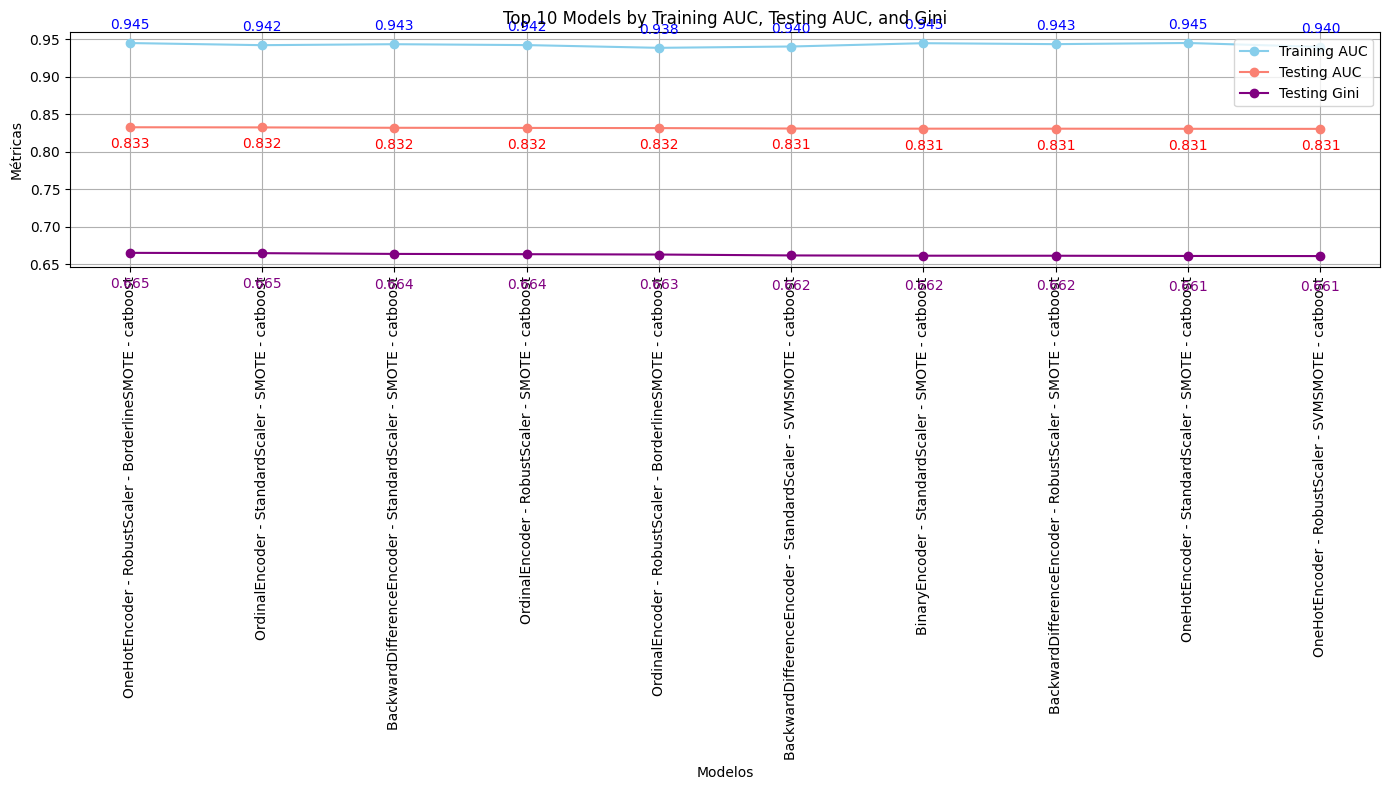

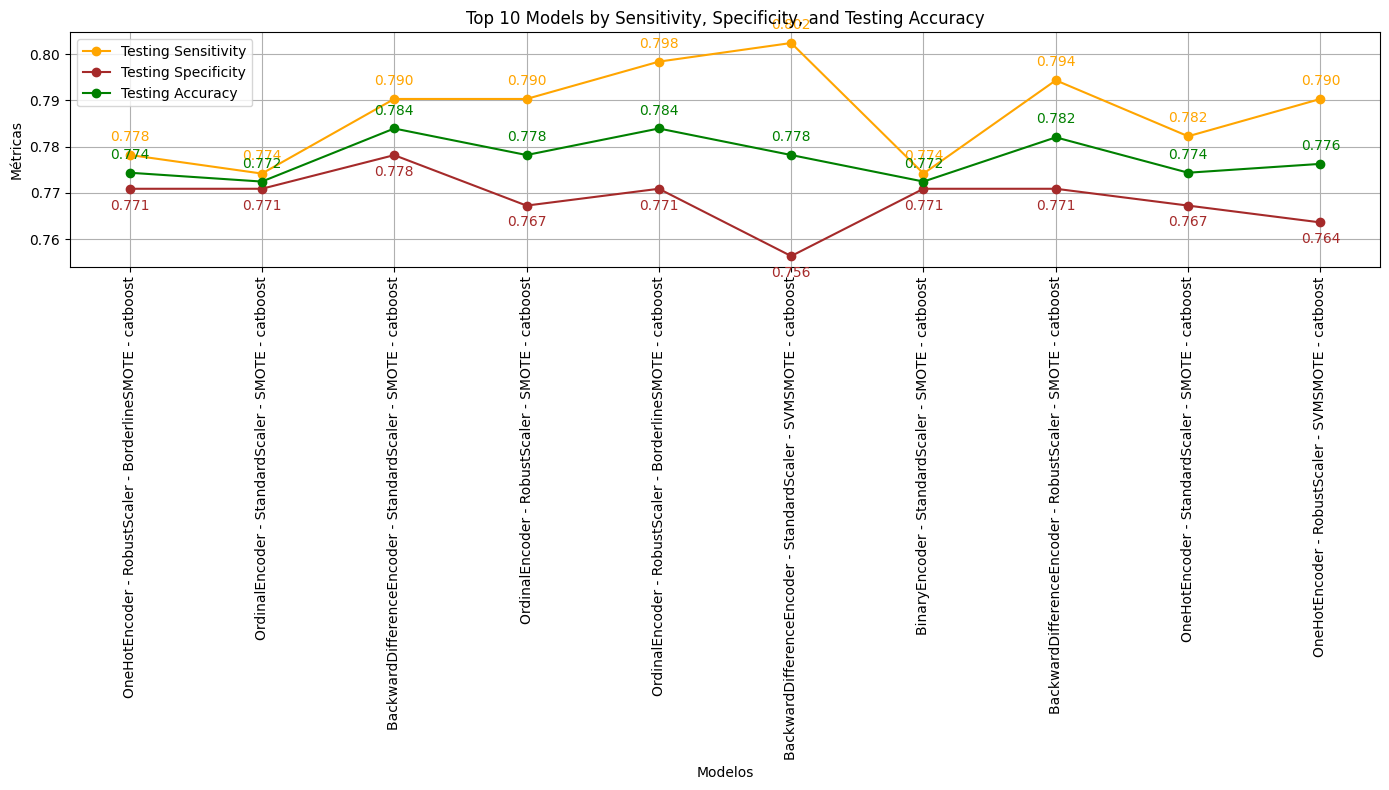

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Consolidar todos los resultados en una lista
consolidated_results = []
for encoded_method, oversampler_method, name, train_auc, test_auc, y_test, predict_test, predict_test_class in all_results:
    full_model_name = f"{encoded_method} - {oversampler_method} - {name}"
    test_accuracy = accuracy_score(y_test, predict_test_class)
    gini_score = 2 * test_auc - 1

    # Calcular sensibilidad y especificidad
    tn, fp, fn, tp = confusion_matrix(y_test, predict_test_class).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    consolidated_results.append((full_model_name, train_auc, test_auc, test_accuracy, gini_score, sensitivity, specificity))

# Ordenar los resultados por test_auc de mayor a menor y seleccionar el top 10
consolidated_results.sort(key=lambda x: x[2], reverse=True)
top_10_results = consolidated_results[:10]

# Desempaquetar los resultados del top 10
(top_10_names, top_10_train_aucs, top_10_test_aucs, 
 top_10_accuracies, top_10_ginis, top_10_sensitivities, 
 top_10_specificities) = zip(*top_10_results)

# Primer gráfico: AUC (train, test) y Gini
plt.figure(figsize=(14, 8))
plt.plot(top_10_names, top_10_train_aucs, label='Training AUC', marker='o', color='skyblue')
plt.plot(top_10_names, top_10_test_aucs, label='Testing AUC', marker='o', color='salmon')
plt.plot(top_10_names, top_10_ginis, label='Testing Gini', marker='o', color='purple')

# Añadir los valores a los puntos
for i, txt in enumerate(top_10_train_aucs):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_train_aucs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
for i, txt in enumerate(top_10_test_aucs):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_test_aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='red')
for i, txt in enumerate(top_10_ginis):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_ginis[i]), textcoords="offset points", xytext=(0,-25), ha='center', color='purple')

plt.xlabel('Modelos')
plt.ylabel('Métricas')
plt.title('Top 10 Models by Training AUC, Testing AUC, and Gini')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Segundo gráfico: Sensibilidad, Especificidad y Accuracy
plt.figure(figsize=(14, 8))
plt.plot(top_10_names, top_10_sensitivities, label='Testing Sensitivity', marker='o', color='orange')
plt.plot(top_10_names, top_10_specificities, label='Testing Specificity', marker='o', color='brown')
plt.plot(top_10_names, top_10_accuracies, label='Testing Accuracy', marker='o', color='green')

# Añadir los valores a los puntos
for i, txt in enumerate(top_10_sensitivities):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_sensitivities[i]), textcoords="offset points", xytext=(0,10), ha='center', color='orange')
for i, txt in enumerate(top_10_specificities):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_specificities[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='brown')
for i, txt in enumerate(top_10_accuracies):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center', color='green')

plt.xlabel('Modelos')
plt.ylabel('Métricas')
plt.title('Top 10 Models by Sensitivity, Specificity, and Testing Accuracy')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
